In [1]:
#in this script we will extract fibroblast cells in the panfetal atlas dataset

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

In [2]:
adata = ad.read_h5ad("/g/data/yr31/hb1618/iPSC_project/datasets/panfetal_whole/panfetal_whole.h5ad")

In [3]:
print(adata)

AnnData object with n_obs × n_vars = 911873 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'


In [4]:
adata.obs['celltype_annotation'].value_counts()

celltype_annotation
MID_ERY                      55104
MACROPHAGE_IRON_RECYCLING    48640
MACROPHAGE_LYVE1_HIGH        35001
NK                           30284
FIBROBLAST_VII               30142
                             ...  
DC_PROGENITOR                  200
PLACENTAL_CONTAMINANTS         132
SKELETAL_MUSCLE                123
LANGERHANS_CELLS                66
PLASMA_B                        61
Name: count, Length: 138, dtype: int64

In [5]:
#first we will subset out the cell type of interest
cell_types_to_keep = ["TYPE_1_INNATE_T"]
adata = adata[adata.obs['celltype_annotation'].isin(cell_types_to_keep)].copy() 

In [6]:
adata.obs['donor'].value_counts()

donor
F51    1533
F50    1058
F30     609
F45     419
F21     373
F29     330
F38     246
F41     212
F67     149
F23     128
F72     128
F33     127
F78     100
F73      96
F34      55
F66      41
F71      35
F64      24
F22      21
F32      19
F35      18
F61       5
F69       1
Name: count, dtype: int64

In [7]:
#performing quality control
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")

In [8]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=True
)

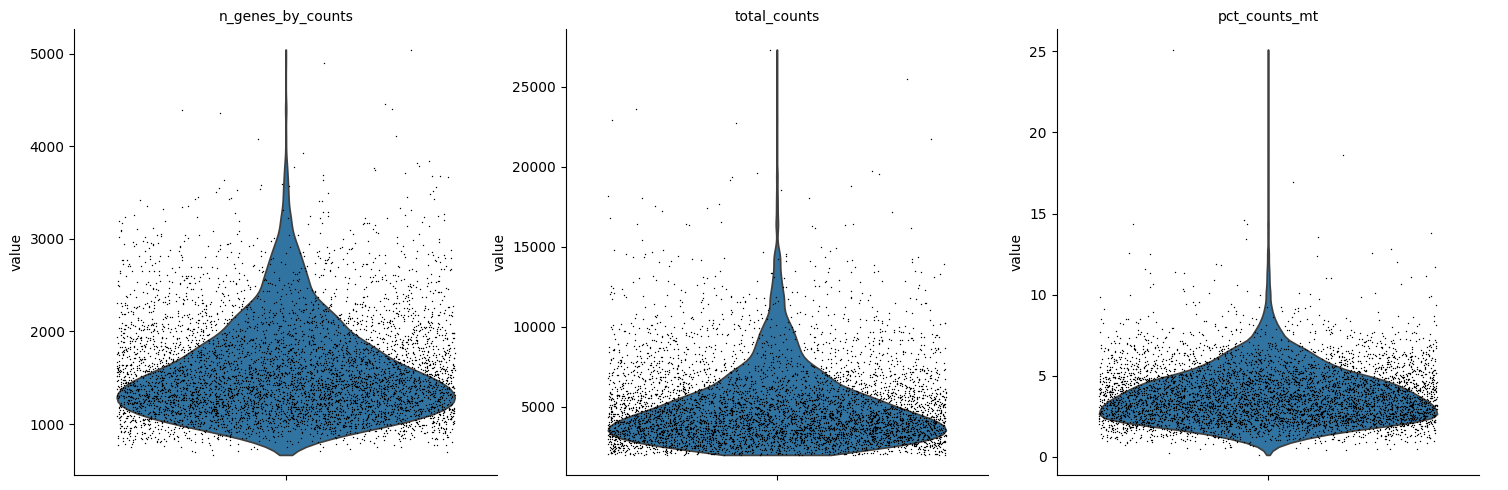

In [9]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

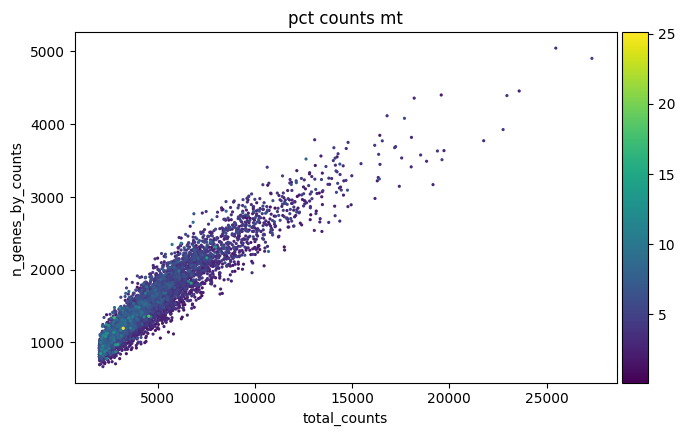

In [10]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [11]:
#it seems that QC has already been applied to the above cells
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs['pct_counts_mt'] < 10].copy()

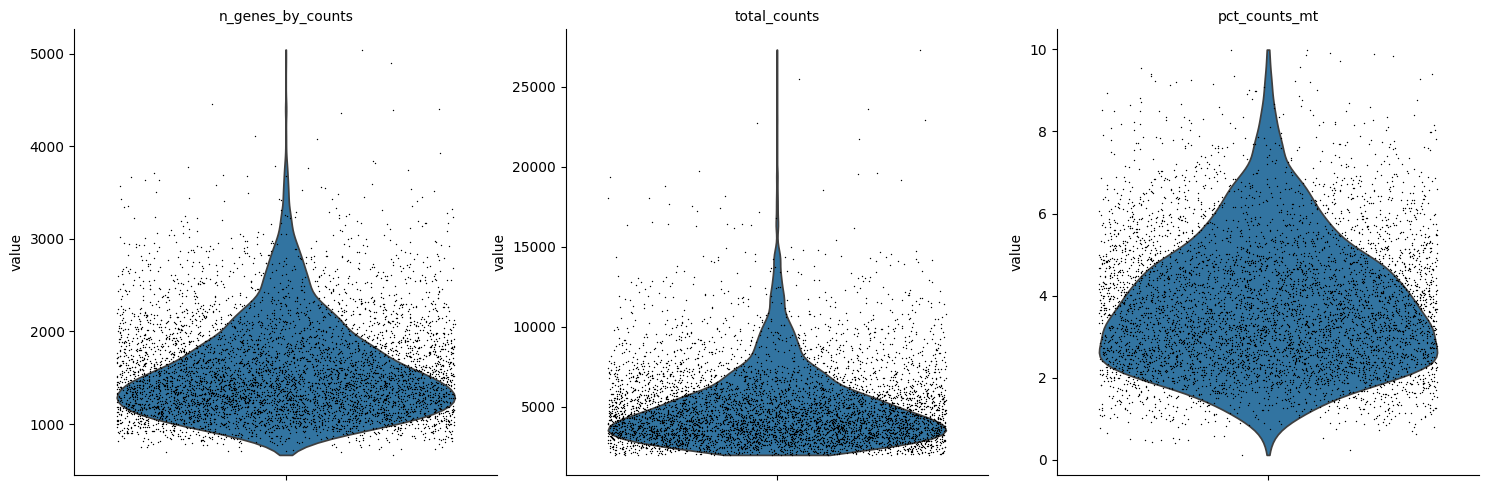

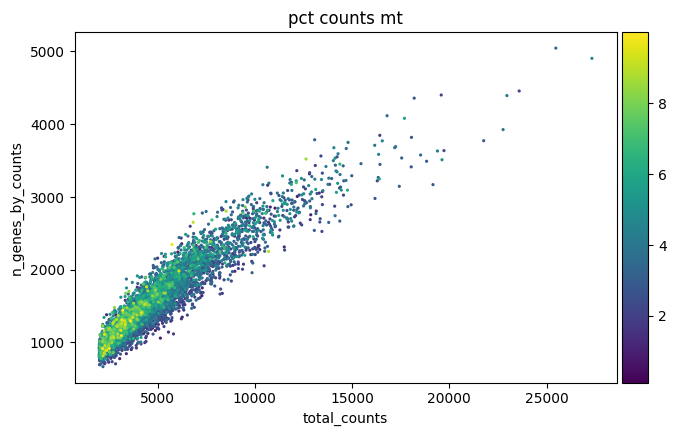

In [12]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [13]:
adata.obs['predicted_doublets'].value_counts()

predicted_doublets
False    5683
True        5
Name: count, dtype: int64

In [14]:
adata = adata[adata.obs['predicted_doublets'] == 'False'].copy()

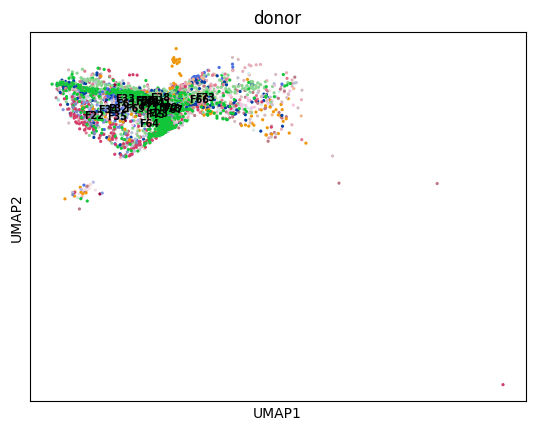

In [15]:
sc.pl.umap(adata,color='donor', legend_loc='on data', legend_fontsize='x-small')

In [16]:
adata.obs['donor'].value_counts()

donor
F51    1517
F50    1047
F30     607
F45     419
F21     372
F29     327
F38     246
F41     212
F67     149
F23     128
F72     128
F33     127
F78      95
F73      94
F34      54
F66      41
F71      34
F64      24
F22      21
F32      19
F35      18
F61       3
F69       1
Name: count, dtype: int64

In [17]:
# In order to get 3-5 donors, and ~5000 cells (in this case ~4000), we will select donors F51, F50, F30, F45, F21
donors_to_keep = ["F51", "F50", "F30", "F45", "F21"]
adata = adata[adata.obs['donor'].isin(donors_to_keep)].copy() 

In [18]:
print(adata)

AnnData object with n_obs × n_vars = 3962 × 16902
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'leiden', 'scvi', 'umap', 'donor_colors'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'


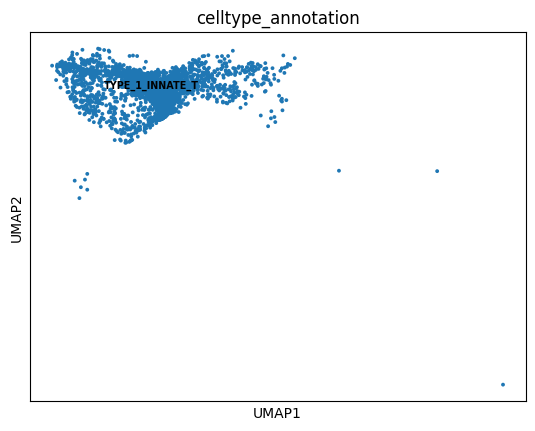

In [19]:
sc.pl.umap(adata,color='celltype_annotation', legend_loc='on data', legend_fontsize='x-small')

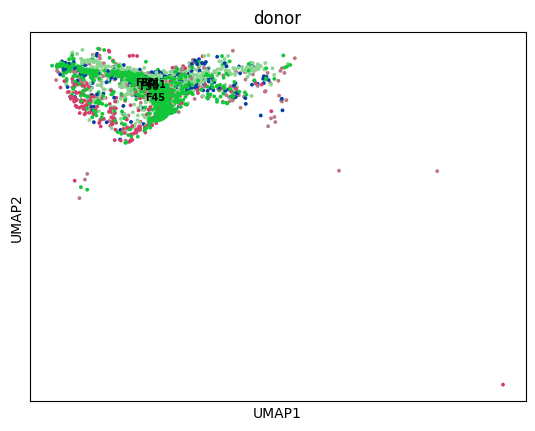

In [20]:
sc.pl.umap(adata,color='donor', legend_loc='on data', legend_fontsize='x-small')

In [21]:
#exporting extracted data
#exporting count data

# Convert to DataFrame with cells as rows, genes as columns
count_df = pd.DataFrame(
    adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X,
    index=adata.obs_names,
    columns=adata.var_names
)

In [22]:
# Save the DataFrame to a .tsv file
count_df.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/iPSC/reference_data/t1_innate_T/countdata.tsv", sep='\t')

In [23]:
#exporting metadata
# Save the observation metadata (cell-level annotations) as a CSV file
adata.obs.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/iPSC/reference_data/t1_innate_T/metadata.csv")